In [1]:
%matplotlib inline
import numpy as np
import nengo    # install with 'pip install nengo', only used to generate dataset
import matplotlib.pyplot as plt

First, let's gnerate some data to use.  I'm just going to do a 1-dimensional signal here (to simplifly plotting), but any shape data will do.  So I'lll just generate some white noise with a maximum frequency and just make a bunch of 1-second clips sampled at 1ms intervals.  So each data point consists of 1000 values.   To generate this, I'm using `nengo.processes.WhiteSignal` (which can be installed with `pip install nengo`).

In [191]:
M = 1000        # size of total dataset
M_train = 50   # size of training dataset
length = 1.0    # amount of time for each element in dataset    
dt = 0.001      # dt for dataset
max_freq = 5.0  # maximum frequency

data = []
for i in range(M):
    data.append(nengo.processes.WhiteSignal(period=length*2, high=max_freq, seed=i).run(length, dt=dt)[:,0])
    
training = np.array(data[:M_train])
testing = np.array(data[M_train:])



Let's plot the first few from the training set and from the test set, just to see what we're working with.

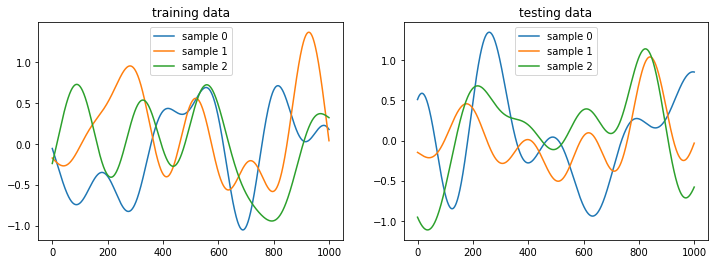

In [192]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(training[:3].T)
plt.legend([f'sample {i}' for i in range(3)])
plt.title('training data')
plt.subplot(1, 2, 2)
plt.plot(testing[:3].T)
plt.title('testing data')
plt.legend([f'sample {i}' for i in range(3)])
plt.show()

Now let's encode the data using the random compressive encoding where each input value gets either a +1 or a -1.  We'll compress this down to D values in this way.

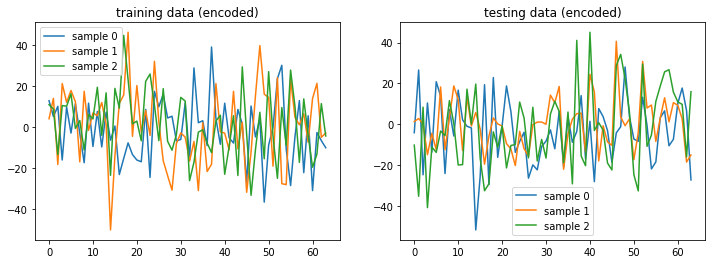

In [193]:
D = 64
encoder = np.random.choice([-1,1], size=(1000, D))

training_encoded = training @ encoder
testing_encoded = testing @ encoder

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(training_encoded[:3].T)
plt.legend([f'sample {i}' for i in range(3)])
plt.title('training data (encoded)')
plt.subplot(1, 2, 2)
plt.plot(testing_encoded[:3].T)
plt.legend([f'sample {i}' for i in range(3)])
plt.title('testing data (encoded)')
plt.show()

Alright, now that we've compressed the data, let's try decompressing it.  The first approach is to just use the transpose of the encoder matrix, since random matrices tend to be their own inverses.  (Well, technically we should use the transpose divided by D, in order to get the scaling right).  To check this, we can plot `encoder @ encoder.T/D` which should look pretty much like the identity function.

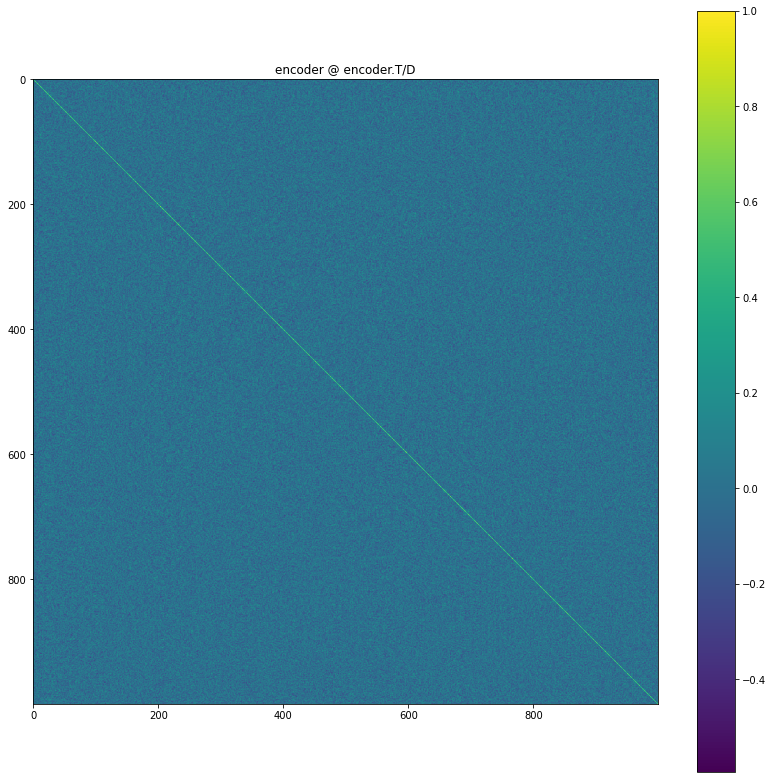

In [194]:
plt.figure(figsize=(14,14))
plt.imshow(encoder @ encoder.T/D)
plt.colorbar()
plt.title('encoder @ encoder.T/D')
plt.show()

Great!  So how well does that work as a decoder?

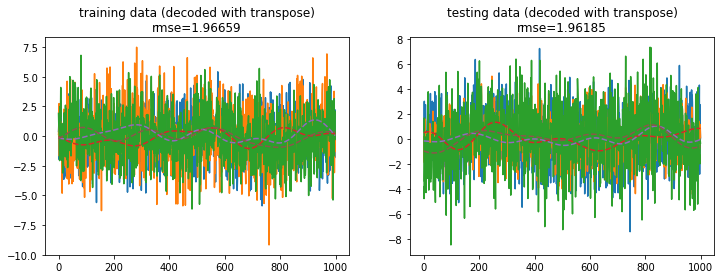

In [195]:
training_decoded_with_transpose = training_encoded @ encoder.T/D
testing_decoded_with_transpose = testing_encoded @ encoder.T/D

train_rmse = np.sqrt(np.mean((training_decoded_with_transpose - training)**2))
test_rmse = np.sqrt(np.mean((testing_decoded_with_transpose - testing)**2))

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(training_decoded_with_transpose[:3].T)
plt.plot(training[:3].T, ls='--')
plt.title('training data (decoded with transpose)\nrmse=%g' % train_rmse)
plt.subplot(1, 2, 2)
plt.plot(testing_decoded_with_transpose[:3].T)
plt.plot(testing[:3].T, ls='--')
plt.title('testing data (decoded with transpose)\nrmse=%g' % test_rmse)
plt.show()

Well that's absolutely horrible.  With larger D it might work a bit better, but it's still really bad.

Maybe we can get a bit better if we use the pseudo inverse instead?

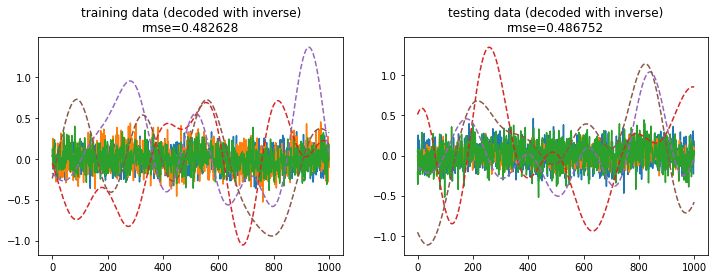

In [196]:
encoder_inv = np.linalg.pinv(encoder)

training_decoded_with_pseudoinverse = (training_encoded @ encoder_inv)
testing_decoded_with_pseudoinverse = (testing_encoded @ encoder_inv)

train_rmse = np.sqrt(np.mean((training_decoded_with_pseudoinverse - training)**2))
test_rmse = np.sqrt(np.mean((testing_decoded_with_pseudoinverse - testing)**2))


plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(training_decoded_with_pseudoinverse[:3].T)
plt.plot(training[:3].T, ls='--')
plt.title('training data (decoded with inverse)\nrmse=%g' % train_rmse)
plt.subplot(1, 2, 2)
plt.plot(testing_decoded_with_pseudoinverse[:3].T)
plt.plot(testing[:3].T, ls='--')
plt.title('testing data (decoded with inverse)\nrmse=%g' % test_rmse)
plt.show()

Well, that's better, but it's still not actually any good.  How can we do better?

One way is to note that we're so far not using our training data for anything.  So what if we tried to find the best linear decoder for the training data?  We can do this simply by doing regression on the encoded data.

To be a little bit more formal, here's the situation, where $A$ is the compressed representation, $X$ is the original data, and we want to find $D$ such that $A D = X$.  So we have:

$A D = X$

$A^T A D = A^T X$

$D = (A^T A)^{-1} A^T X$

And, of course, if you add in a regularization term, this is just ridge regression

$
D = (A^T A + \lambda I)^{-1} A^T X
$

(Note: this can also be thought of as minimizing $(A D - X)^2 + \lambda \sum D_i^2$ or as minimizing $((A+N(0,\lambda)) D - X)^2$.  In other words, finding D while keeping the magnitude of its values small, or finding D subject to gaussian noise on your measurements.  I still find it amazing that those three ways of thinking about it are all the same thing!)

In any case, let's give it a try:

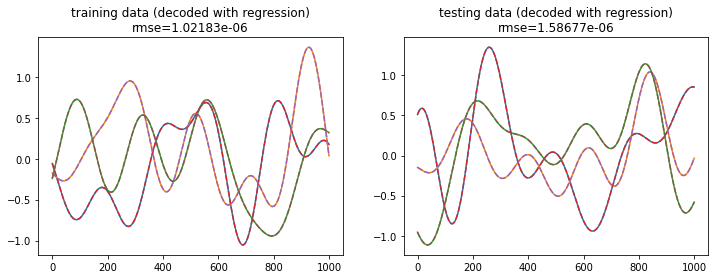

In [201]:
reg = 1e-5
decoder = np.linalg.pinv(training_encoded.T @ training_encoded + reg*np.identity(D)) @ (training_encoded.T @ training)

training_decoded_with_regression = (training_encoded @ decoder)
testing_decoded_with_regression = (testing_encoded @ decoder)

train_rmse = np.sqrt(np.mean((training_decoded_with_regression - training)**2))
test_rmse = np.sqrt(np.mean((testing_decoded_with_regression - testing)**2))

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(training_decoded_with_regression[:3].T)
plt.plot(training[:3].T, ls='--')
plt.title('training data (decoded with regression)\nrmse=%g' % train_rmse)
plt.subplot(1, 2, 2)
plt.plot(testing_decoded_with_regression[:3].T)
plt.plot(testing[:3].T, ls='--')
plt.title('testing data (decoded with regression)\nrmse=%g' % test_rmse)
plt.show()

Now that works extremely well.  To get a bit better we might want to try adjusting the regularization term, or the amount of training data.